# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

import ast
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
import pickle

import re
import contextlib

import math

import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels

from scipy.stats import gaussian_kde
from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import pickle

import torch.nn.functional as F


import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

import joblib

d:\miniconda3\envs\GPTG\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


# Data

In [2]:
X_train = pd.read_csv('RealCase/RealCase_X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('RealCase/RealCase_X_test.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('RealCase/RealCase_Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('RealCase/RealCase_Y_test_std.csv', header=None, delimiter=',').values
Realcase_data_std = pd.read_csv('RealCase/RealCase_Y_std.csv', header=None, delimiter=',').values

Y_train = pd.read_csv('RealCase/RealCase_Y_train.csv', header=None, delimiter=',').values
Y_test = pd.read_csv('RealCase/RealCase_Y_test.csv', header=None, delimiter=',').values
Realcase_data = pd.read_csv('RealCase/RealCase.csv', header=None, delimiter=',').values


In [3]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)
realcase_y = torch.tensor(Realcase_data_std, dtype=torch.float32)


# Emulator

In [4]:
Device = 'cuda'

In [5]:
checkpoint = torch.load('multitask_gp_checkpoint_Realcase.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y, 
                                               num_latents=model_params['num_latents'],
                                               num_inducing=model_params['num_inducing'],  
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])

MVGP_models.eval()
MVGP_likelihoods.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

# MCMC Samples

In [6]:
loaded_samples = torch.load("mcmc_RealCase_final_mcmc_infer_2block_independent.pt", map_location=Device)

In [18]:
posterior_samples = Tools.extract_vector_params_from_mcmc(
    loaded_samples,
    key="params",
    param_names=[f"theta_{i}" for i in range(10)]  # 你也可以用真实参数名
)


In [19]:
keys_to_extract = ['sigma_meas_1', 'sigma_meas_2']
posterior_samples.update({k: loaded_samples[k] for k in keys_to_extract})

# MCMC Plots

theta_0: R-hat = 1.000, split R-hat = 1.000, ESS = 1061.8


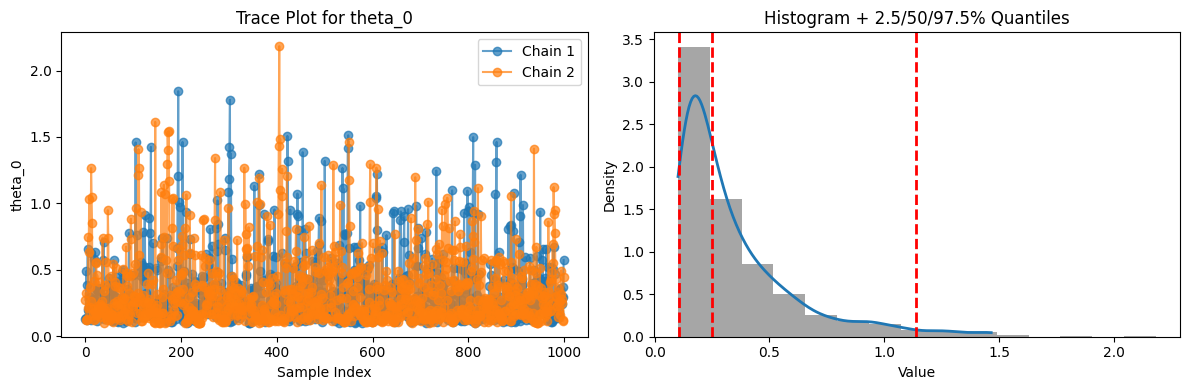

<Figure size 600x400 with 0 Axes>

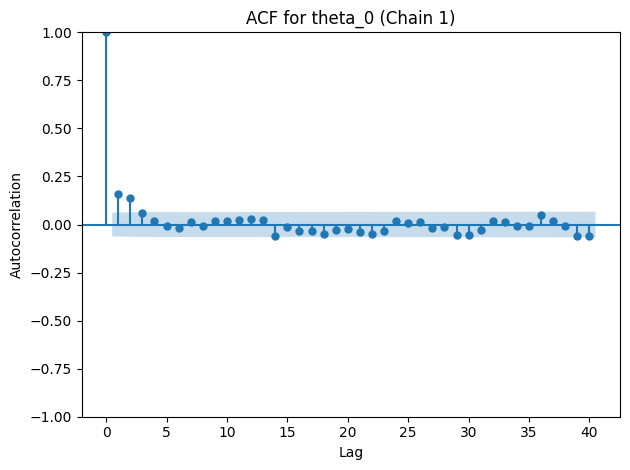

theta_1: R-hat = 1.000, split R-hat = 0.999, ESS = 1381.7


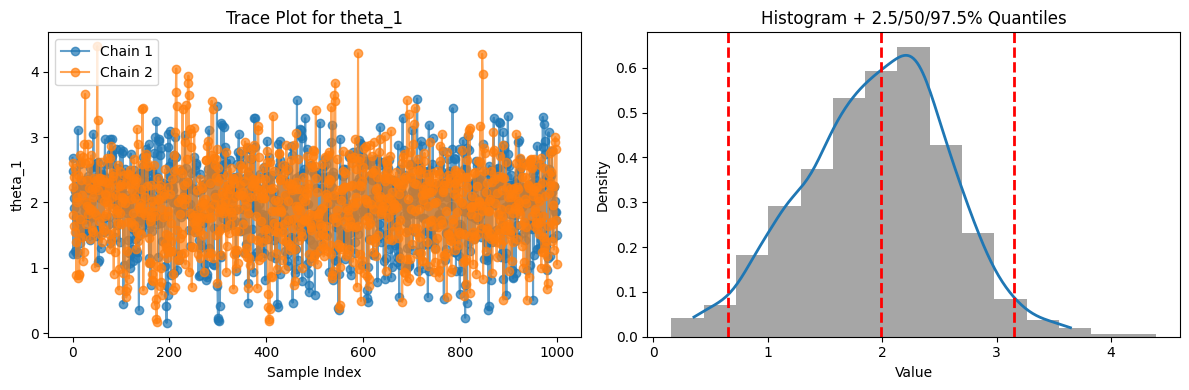

<Figure size 600x400 with 0 Axes>

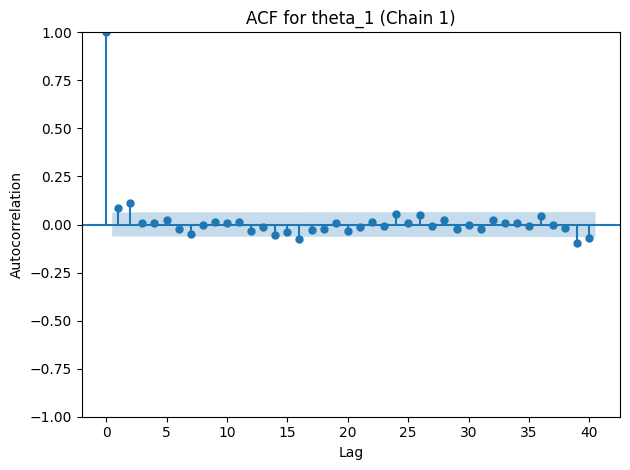

theta_2: R-hat = 1.000, split R-hat = 1.001, ESS = 1646.9


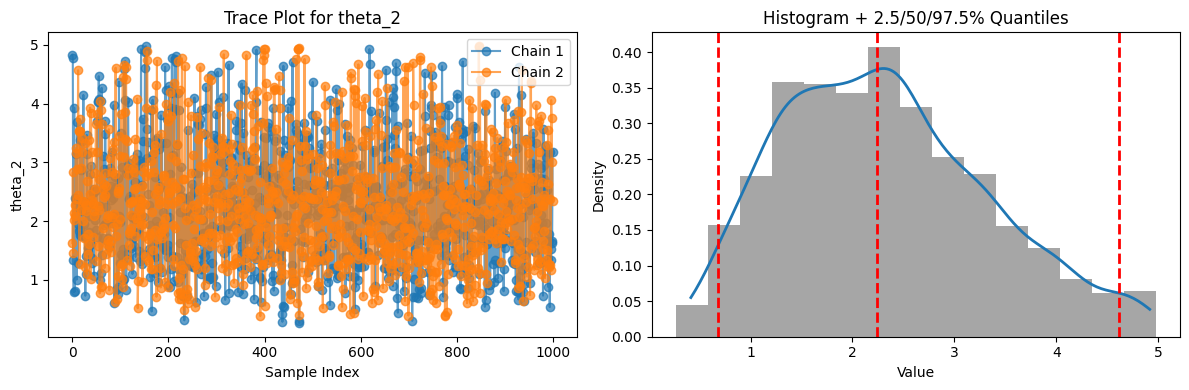

<Figure size 600x400 with 0 Axes>

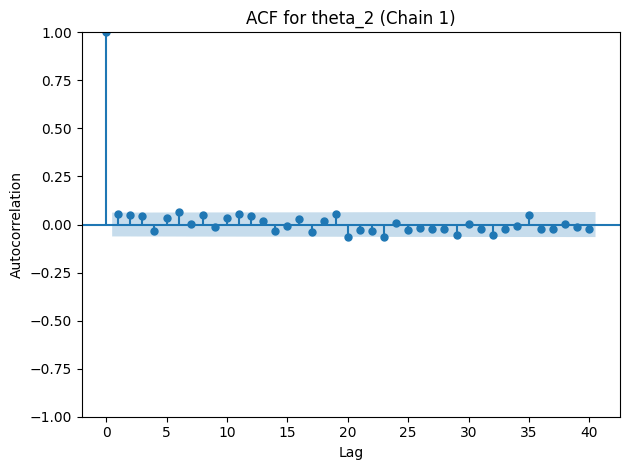

theta_3: R-hat = 1.000, split R-hat = 0.999, ESS = 1538.0


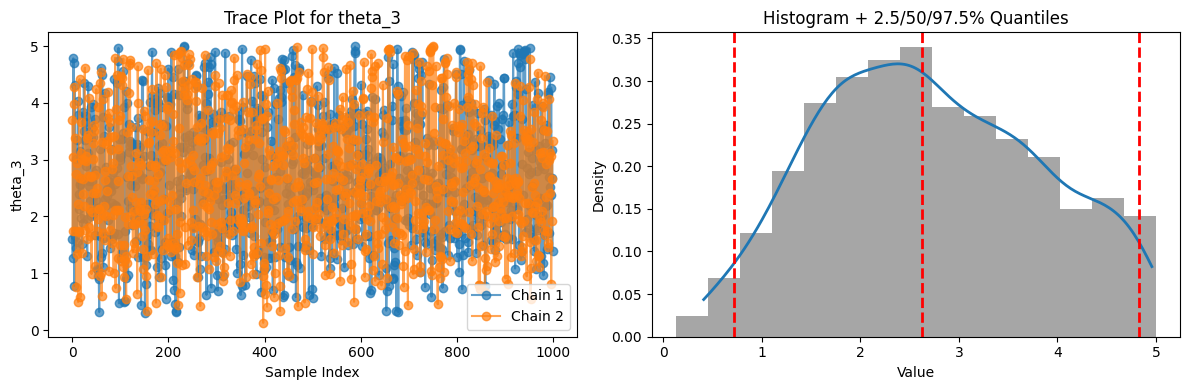

<Figure size 600x400 with 0 Axes>

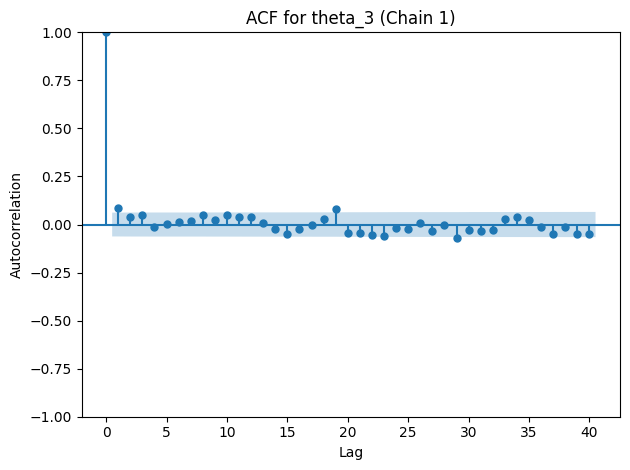

theta_4: R-hat = 1.000, split R-hat = 1.000, ESS = 1021.0


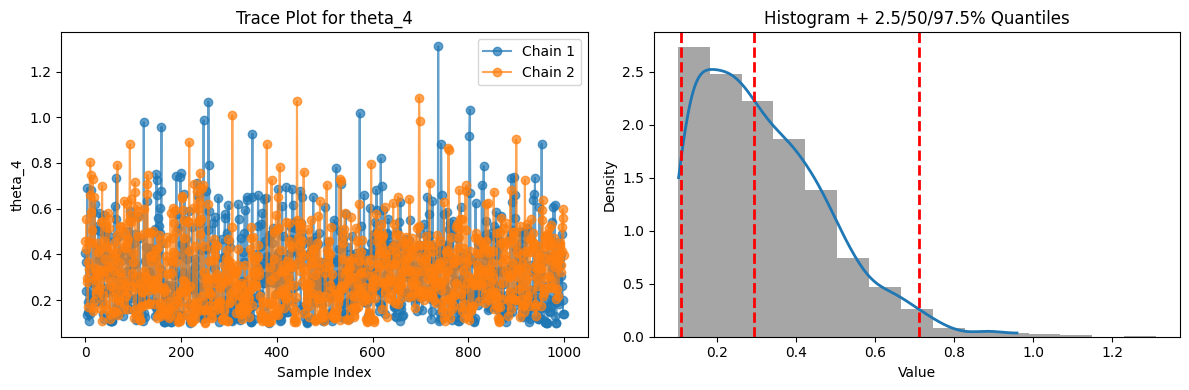

<Figure size 600x400 with 0 Axes>

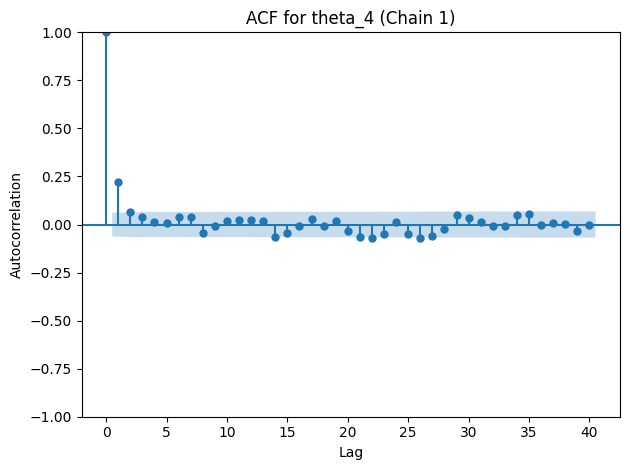

theta_5: R-hat = 1.002, split R-hat = 1.004, ESS = 811.3


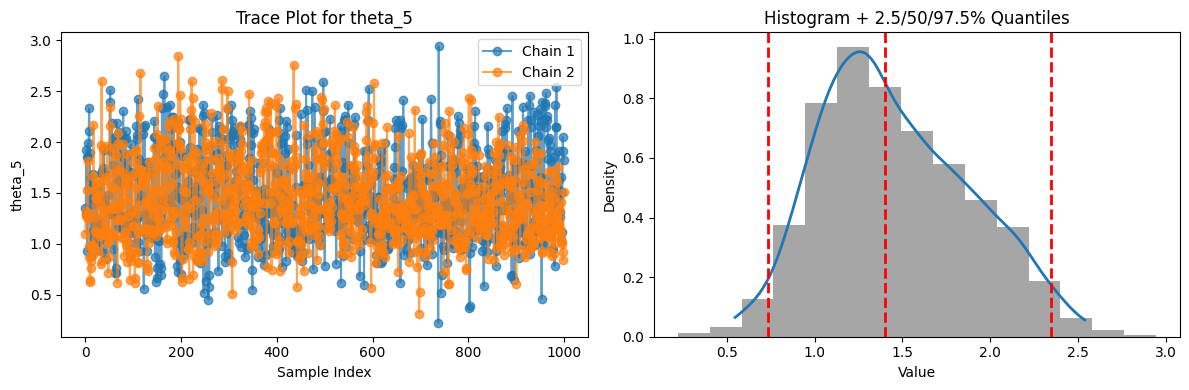

<Figure size 600x400 with 0 Axes>

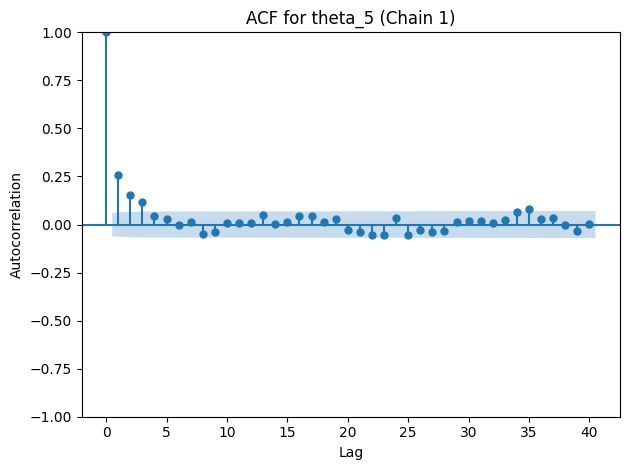

theta_6: R-hat = 1.000, split R-hat = 1.002, ESS = 859.9


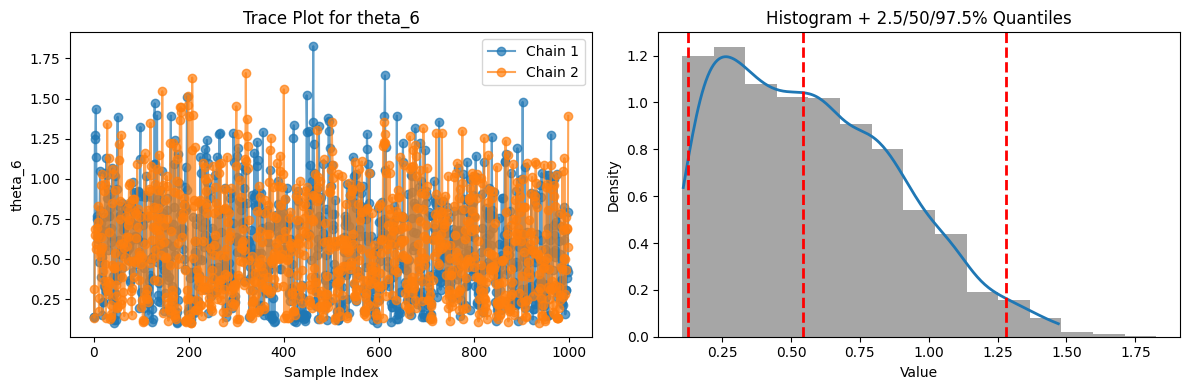

<Figure size 600x400 with 0 Axes>

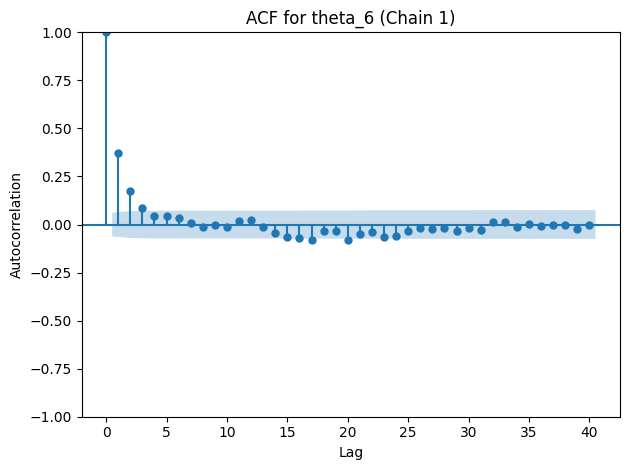

theta_7: R-hat = 1.000, split R-hat = 1.001, ESS = 711.3


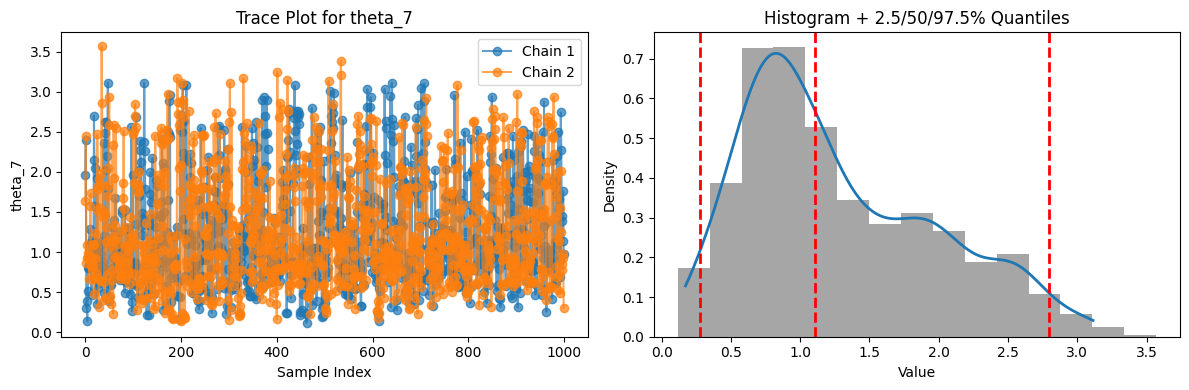

<Figure size 600x400 with 0 Axes>

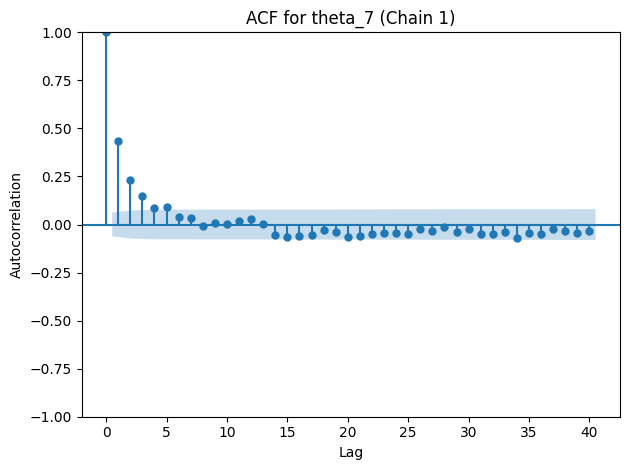

theta_8: R-hat = 1.000, split R-hat = 1.001, ESS = 728.5


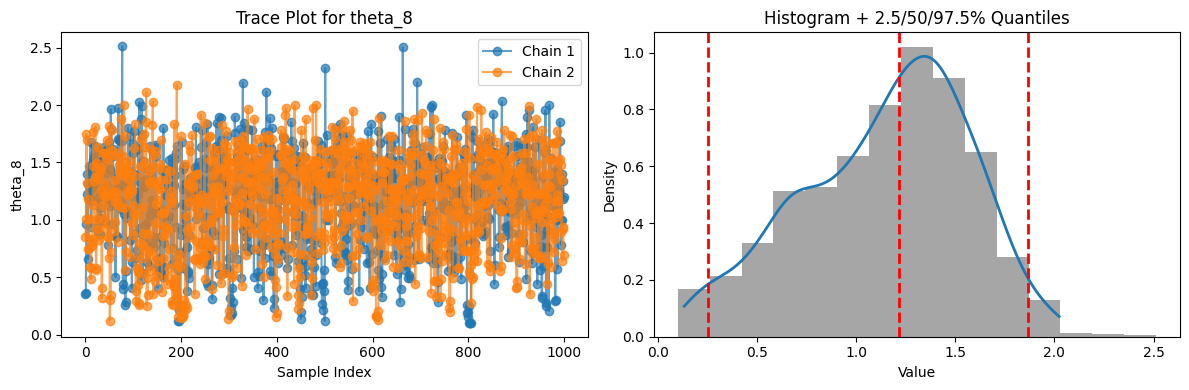

<Figure size 600x400 with 0 Axes>

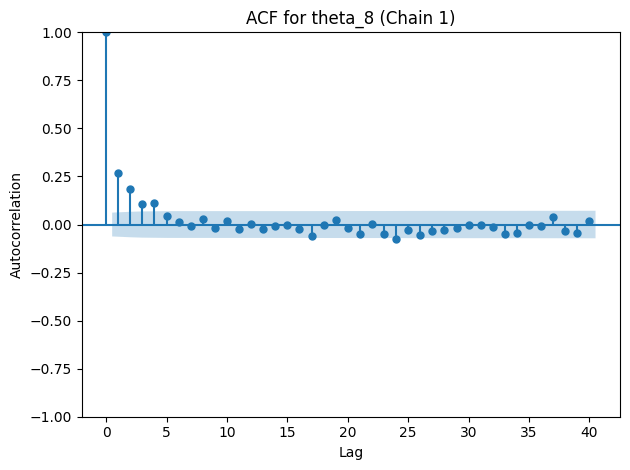

theta_9: R-hat = 1.000, split R-hat = 1.003, ESS = 441.5


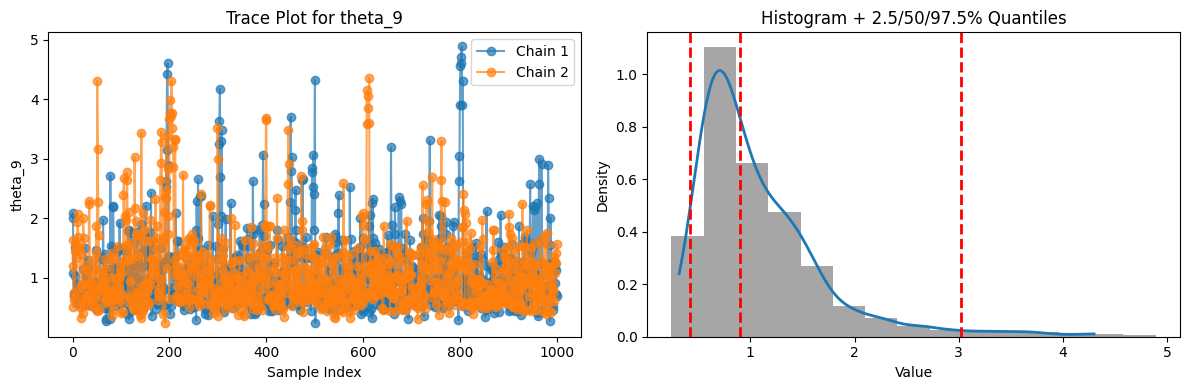

<Figure size 600x400 with 0 Axes>

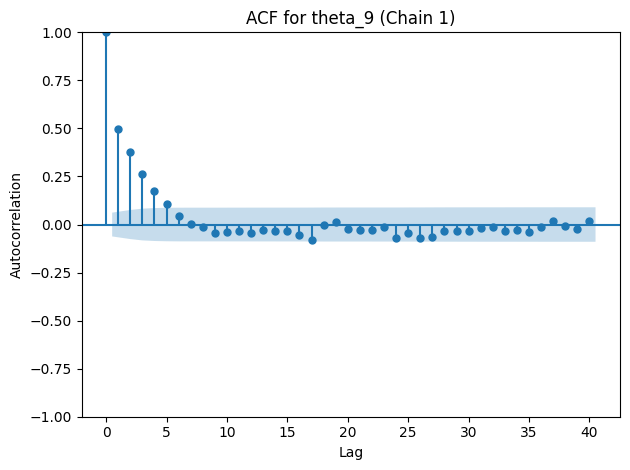

sigma_meas_1: R-hat = 1.000, split R-hat = 0.999, ESS = 1762.9


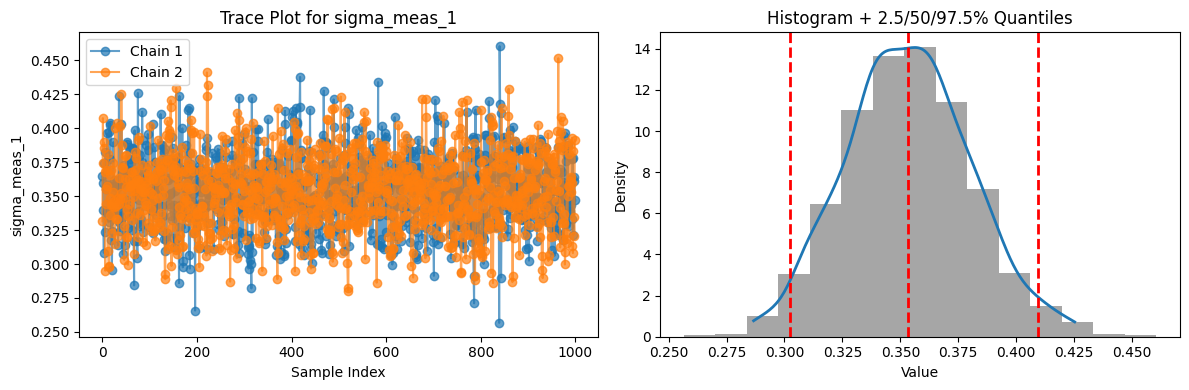

<Figure size 600x400 with 0 Axes>

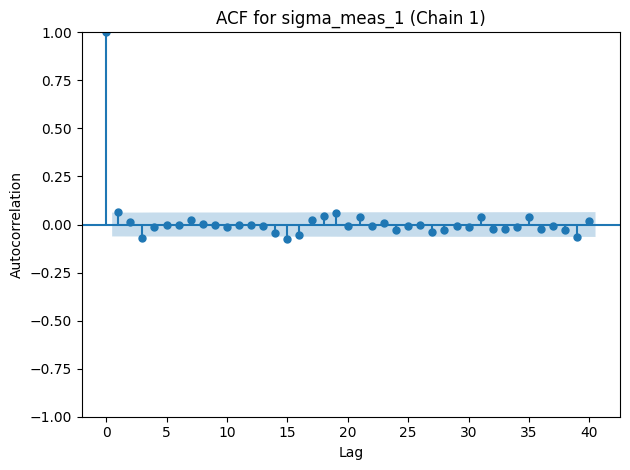

sigma_meas_2: R-hat = 1.000, split R-hat = 1.001, ESS = 1563.9


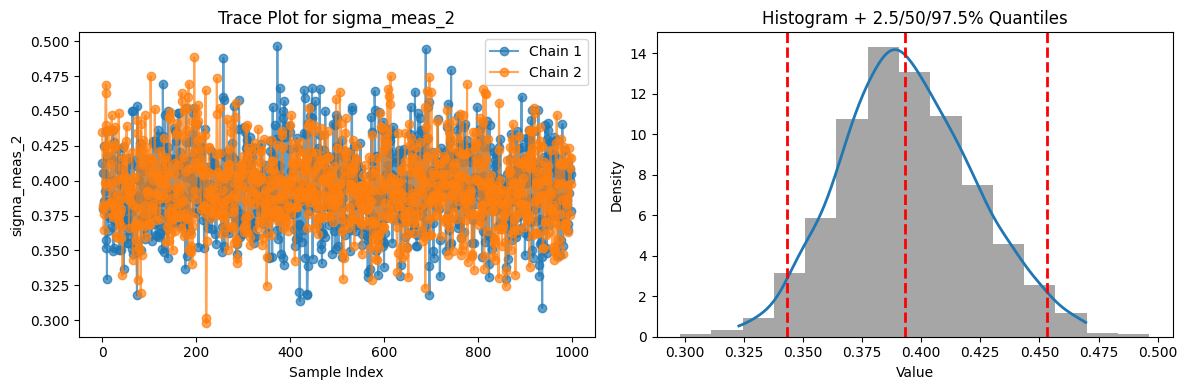

<Figure size 600x400 with 0 Axes>

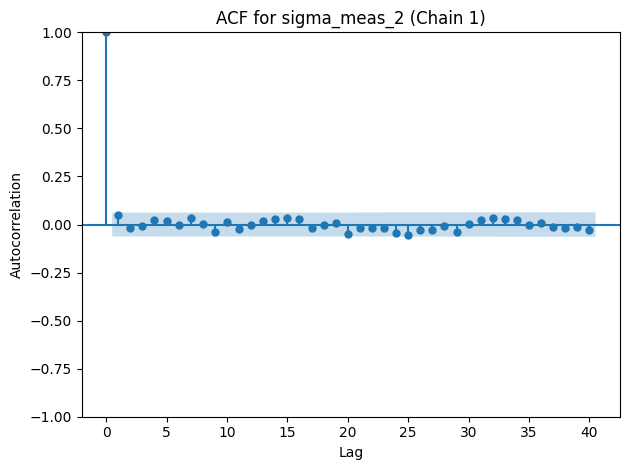

In [25]:
Tools.visualize_posterior_1d_params(
    posterior_samples,
    bins=15,
    acf_lags=40,
    clip_percentiles=(0.5, 99.5),
    xlim=None,
    # xlim=(-0.1, 5.5),
)

# Posterior predictive resample

In [7]:
@torch.no_grad()
def posterior_predictive_resample_2block_cuda(
    samples,
    Pre_function,
    Models,
    Likelihoods,
    num_draws=20,
    *,
    device="cuda",          # ← 改为 cuda
    chunk_size=256,
    group_by_chain=False,
    use_fast_pred_var=False,
    return_mean_var=False,
    use_rsample=True,
    D=33,
    jitter=1e-6,
):
    # ---- 设备检查 ----
    device = torch.device(device)
    if device.type == "cuda" and not torch.cuda.is_available():
        print("[Warning] CUDA 不可用，回退到 CPU")
        device = torch.device("cpu")

    def flatten_chain(x: torch.Tensor) -> torch.Tensor:
        if group_by_chain and x.dim() >= 2:
            return x.reshape(-1, *x.shape[2:])
        return x

    # ---- 1) 提取参数，直接搬到 GPU ----
    for key in ("params", "sigma_meas_1", "sigma_meas_2"):
        if key not in samples:
            raise KeyError(f"samples 中未找到 '{key}'")

    theta_all  = flatten_chain(samples["params"]).to(device=device, dtype=torch.float32)
    sigma1_all = flatten_chain(samples["sigma_meas_1"]).to(device=device, dtype=torch.float32)
    sigma2_all = flatten_chain(samples["sigma_meas_2"]).to(device=device, dtype=torch.float32)

    S_total, P = theta_all.shape

    # ---- 2) 将模型搬到 GPU ----
    def _to_device_and_eval(obj):
        if isinstance(obj, (list, tuple)):
            for m in obj:
                if hasattr(m, "to"):   m.to(device)
                if hasattr(m, "eval"): m.eval()
        else:
            try:
                obj.to(device)
                obj.eval()
            except Exception:
                pass

    _to_device_and_eval(Models)
    _to_device_and_eval(Likelihoods)

    # ---- 3) 预分配 jitter & eye（避免循环内重复创建）----
    eye_D = torch.eye(D, device=device, dtype=torch.float32)

    def _build_sigma_meas_batch(s1: torch.Tensor, s2: torch.Tensor) -> torch.Tensor:
        """
        全程在 GPU 上构造 [B, D, D] 对角块测量噪声矩阵。
        diag_embed 比循环快得多。
        """
        B = s1.shape[0]
        diags = torch.zeros(B, D, device=device, dtype=torch.float32)
        diags[:, 1:17]  = s1.pow(2).unsqueeze(1).expand(B, 16)
        diags[:, 17:33] = s2.pow(2).unsqueeze(1).expand(B, 16)
        return torch.diag_embed(diags)   # [B, D, D]

    def _sample_with_noise(pred_dist, Sigma_meas_batch, B, sample_shape):
        """叠加测量噪声后从 GPU 上的分布采样，返回 [B, num_draws, D]（仍在 GPU）"""
        mu    = pred_dist.mean
        Sigma = pred_dist.covariance_matrix

        if mu.dim()    == 3 and mu.shape[0]    == 1: mu    = mu.squeeze(0)
        if Sigma.dim() == 4 and Sigma.shape[0] == 1: Sigma = Sigma.squeeze(0)

        # 确保在同一设备
        mu    = mu.to(device)
        Sigma = Sigma.to(device)

        Sigma_total = Sigma + Sigma_meas_batch + jitter * eye_D.unsqueeze(0)

        noisy_dist = torch.distributions.MultivariateNormal(
            loc=mu, covariance_matrix=Sigma_total
        )

        draws = noisy_dist.rsample(sample_shape) if use_rsample else noisy_dist.sample(sample_shape)
        # [num_draws, B, D] -> [B, num_draws, D]
        return draws.permute(1, 0, 2).contiguous()

    # ---- 4) 分块采样（结果暂存 GPU list，最后一次性 cat 后转 CPU）----
    sample_shape = torch.Size([num_draws] if isinstance(num_draws, int) else list(num_draws))

    y_chunks    = []
    mean_chunks = []
    var_chunks  = []

    fast_ctx = contextlib.nullcontext()
    if use_fast_pred_var:
        import gpytorch
        fast_ctx = gpytorch.settings.fast_pred_var()

    with fast_ctx:
        for start in range(0, S_total, chunk_size):
            end = min(start + chunk_size, S_total)
            th = theta_all[start:end]   # [B, P]  on GPU
            s1 = sigma1_all[start:end]  # [B]     on GPU
            s2 = sigma2_all[start:end]  # [B]     on GPU
            B  = th.shape[0]

            Sigma_meas_batch = _build_sigma_meas_batch(s1, s2)  # [B,D,D] on GPU

            try:
                pred_dist = Pre_function(Models, Likelihoods, th)
                draws = _sample_with_noise(pred_dist, Sigma_meas_batch, B, sample_shape)
                # ← 暂时保留在 GPU，积累完再统一转 CPU
                y_chunks.append(draws)

                if return_mean_var:
                    mu  = pred_dist.mean
                    var = pred_dist.variance
                    if mu.dim()  == 3 and mu.shape[0]  == 1: mu  = mu.squeeze(0)
                    if var.dim() == 3 and var.shape[0] == 1: var = var.squeeze(0)
                    mean_chunks.append(mu.to(device))
                    var_chunks.append(var.to(device))

            except Exception as e:
                # fallback: 逐个 theta（GPU 内循环，不搬 CPU）
                draws_list, mean_list, var_list = [], [], []
                for i in range(B):
                    pred_i  = Pre_function(Models, Likelihoods, th[i].unsqueeze(0))
                    Sm_i    = Sigma_meas_batch[i].unsqueeze(0)
                    d_i     = _sample_with_noise(pred_i, Sm_i, 1, sample_shape)
                    draws_list.append(d_i.squeeze(0))
                    if return_mean_var:
                        mean_list.append(pred_i.mean.squeeze(0).to(device))
                        var_list.append(pred_i.variance.squeeze(0).to(device))

                y_chunks.append(torch.stack(draws_list, dim=0))
                if return_mean_var:
                    mean_chunks.append(torch.stack(mean_list))
                    var_chunks.append(torch.stack(var_list))

    # ---- 5) 统一 cat 后一次性搬 CPU（最小化 PCIe 传输次数）----
    y_pp       = torch.cat(y_chunks,    dim=0).cpu()   # [S_total, num_draws, D]
    theta_cpu  = theta_all.cpu()
    sigma1_cpu = sigma1_all.cpu()
    sigma2_cpu = sigma2_all.cpu()

    if return_mean_var:
        return (
            theta_cpu, y_pp, sigma1_cpu, sigma2_cpu,
            torch.cat(mean_chunks, dim=0).cpu(),
            torch.cat(var_chunks,  dim=0).cpu(),
        )
    return theta_cpu, y_pp, sigma1_cpu, sigma2_cpu

In [26]:
posterior_samples = Tools.extract_vector_params_from_mcmc(
    loaded_samples,
    key="params",
    param_names=[f"theta_{i}" for i in range(10)]  # 你也可以用真实参数名
)


In [27]:
def _sorted_param_keys(sample_dict):
    """
    支持 key 形如:
      - "param_0", "param_1", ...
      - "theta_0", "theta_1", ...
      - 任何以 _数字 结尾的 key
    """
    def idx(k: str) -> int:
        m = re.search(r"(\d+)$", k)
        if m is None:
            raise ValueError(f"Cannot parse index from key='{k}'. Expect suffix like _0, _1, ...")
        return int(m.group(1))

    return sorted(sample_dict.keys(), key=idx)


@torch.no_grad()
def posterior_predictive_resample(
    samples,
    Pre_function,
    Models,
    Likelihoods,
    num_draws=20,
    *,
    device="cpu",
    chunk_size=256,
    group_by_chain=False,      # True: samples[k] is [C,S,...] -> flatten to [C*S,...]
    use_fast_pred_var=False,   # 如果你在 Pre_function 内部已经开了 fast_pred_var，就设 False
    return_mean_var=False,     # 可选：同时返回每个 theta 的预测 mean/var
    use_rsample=True,          # True: rsample; False: sample
):
    """
    Posterior predictive resampling for GPyTorch multitask GP predictions.

    Parameters
    ----------
    samples : dict[str, Tensor]
        MCMC samples dict, each key maps to Tensor on CPU or GPU.
        Typical shapes:
          - [S] for single-chain
          - [C,S] for multi-chain (if group_by_chain=True will flatten)

    Pre_function : callable(model, likelihood, x)
        Should return a GPyTorch distribution, e.g. MultitaskMultivariateNormal

    Returns
    -------
    theta_all : Tensor [S_total, P]  (CPU)
    y_pp      : Tensor [S_total, num_draws, D]  (CPU)
    (optional) mean_all : Tensor [S_total, D] (CPU)
    (optional) var_all  : Tensor [S_total, D] (CPU)
    """

    # ---- 0) make sample_shape torch.Size (GPyTorch rsample expects torch.Size in some versions) ----
    if isinstance(num_draws, int):
        sample_shape = torch.Size([num_draws])
    else:
        # allow user pass tuple/list like (n,) or [n]
        sample_shape = torch.Size(list(num_draws))

    keys = _sorted_param_keys(samples)

    def flatten_chain(x: torch.Tensor) -> torch.Tensor:
        # If multi-chain tensor [C,S,...] and group_by_chain=True -> [C*S,...]
        if group_by_chain and x.dim() >= 2:
            return x.reshape(-1, *x.shape[2:])
        return x

    device = torch.device(device)

    # ---- 1) build theta_all: [S_total, P] ----
    param_list = []
    for k in keys:
        x = flatten_chain(samples[k])
        x = x.to(device=device, dtype=torch.float32)
        # Expect x is [S_total] for scalar params, or [S_total, ...] if vector params
        param_list.append(x)

    # Stack last dim as parameter dim P
    # Scalar params -> theta_all [S_total, P]
    theta_all = torch.stack(param_list, dim=-1)
    S_total, P = theta_all.shape

    # ---- 2) set eval mode (supports single model or list/tuple) ----
    try:
        Models.eval()
    except Exception:
        if isinstance(Models, (list, tuple)):
            for m in Models:
                if hasattr(m, "eval"):
                    m.eval()

    try:
        Likelihoods.eval()
    except Exception:
        if isinstance(Likelihoods, (list, tuple)):
            for l in Likelihoods:
                if hasattr(l, "eval"):
                    l.eval()

    # ---- 3) chunked posterior predictive sampling ----
    y_chunks = []
    mean_chunks, var_chunks = [], []

    fast_ctx = None
    if use_fast_pred_var:
        import gpytorch
        fast_ctx = gpytorch.settings.fast_pred_var()

    # helper: normalize draws to [B, num_draws, D]
    def _to_BSD(draws: torch.Tensor, B: int) -> torch.Tensor:
        """
        Common cases:
          - [num_draws, B, D]
          - [num_draws, 1, B, D]  (extra singleton batch)
          - [num_draws, B, 1, D]  (extra singleton batch)
          - [num_draws, D]        (B==1)
        Return:
          - [B, num_draws, D]
        """
        if draws.dim() == 4:
            # [num_draws, 1, B, D] -> [num_draws, B, D]
            if draws.shape[1] == 1 and draws.shape[2] == B:
                draws = draws.squeeze(1)
            # [num_draws, B, 1, D] -> [num_draws, B, D]
            elif draws.shape[2] == 1 and draws.shape[1] == B:
                draws = draws.squeeze(2)

        if draws.dim() == 2:
            # [num_draws, D] -> [num_draws, 1, D]
            draws = draws.unsqueeze(1)

        if draws.dim() != 3:
            raise RuntimeError(f"Unexpected draws shape {tuple(draws.shape)}; cannot convert to [B,S,D].")

        # now [num_draws, B, D] -> [B, num_draws, D]
        if draws.shape[1] != B:
            raise RuntimeError(
                f"Draws has shape {tuple(draws.shape)}; expected second dim == B={B}."
            )
        return draws.permute(1, 0, 2).contiguous()

    # helper: normalize mean/var to [B, D]
    def _to_BD(x: torch.Tensor, B: int) -> torch.Tensor:
        """
        Common cases:
          - [B, D]
          - [1, B, D]
          - [B] or [1, D] shouldn't happen for multitask, but handle minimally
        """
        if x.dim() == 3 and x.shape[0] == 1 and x.shape[1] == B:
            x = x.squeeze(0)
        if x.dim() == 2 and x.shape[0] == B:
            return x
        if x.dim() == 1 and B == 1:
            # [D] -> [1, D]
            return x.unsqueeze(0)
        raise RuntimeError(f"Unexpected mean/var shape {tuple(x.shape)}; expected [B,D] (B={B}).")

    with (fast_ctx if fast_ctx is not None else contextlib.nullcontext()):
        for start in range(0, S_total, chunk_size):
            th = theta_all[start:start + chunk_size]  # [B, P]
            B = th.shape[0]

            # 3.1 preferred: vectorized call
            try:
                pred_dist = Pre_function(Models, Likelihoods, th)

                if use_rsample and hasattr(pred_dist, "rsample"):
                    draws = pred_dist.rsample(sample_shape=sample_shape)
                else:
                    draws = pred_dist.sample(sample_shape=sample_shape)

                draws = _to_BSD(draws, B)  # [B, num_draws, D]
                y_chunks.append(draws.detach().cpu())

                if return_mean_var:
                    mean = _to_BD(pred_dist.mean, B)
                    var = _to_BD(pred_dist.variance, B)
                    mean_chunks.append(mean.detach().cpu())
                    var_chunks.append(var.detach().cpu())

            except Exception:
                # 3.2 fallback: per-theta loop
                draws_list = []
                mean_list, var_list = [], []

                for i in range(B):
                    pred_i = Pre_function(Models, Likelihoods, th[i].unsqueeze(0))  # [1,P]

                    if use_rsample and hasattr(pred_i, "rsample"):
                        d_i = pred_i.rsample(sample_shape=sample_shape)
                    else:
                        d_i = pred_i.sample(sample_shape=sample_shape)

                    # expected [num_draws, 1, D] or [num_draws, D]
                    if d_i.dim() == 3 and d_i.shape[1] == 1:
                        d_i = d_i.squeeze(1)  # [num_draws, D]
                    if d_i.dim() == 2:
                        pass
                    else:
                        raise RuntimeError(f"Unexpected per-theta draws shape {tuple(d_i.shape)}")

                    draws_list.append(d_i)

                    if return_mean_var:
                        # pred_i.mean likely [1,D]
                        mean_list.append(pred_i.mean.squeeze(0))
                        var_list.append(pred_i.variance.squeeze(0))

                # stack: B * [num_draws, D] -> [B, num_draws, D]
                draws = torch.stack(draws_list, dim=0)
                y_chunks.append(draws.detach().cpu())

                if return_mean_var:
                    mean_chunks.append(torch.stack(mean_list, dim=0).detach().cpu())
                    var_chunks.append(torch.stack(var_list, dim=0).detach().cpu())

    y_pp = torch.cat(y_chunks, dim=0)  # [S_total, num_draws, D]
    theta_cpu = theta_all.detach().cpu()

    if return_mean_var:
        mean_all = torch.cat(mean_chunks, dim=0)  # [S_total, D]
        var_all = torch.cat(var_chunks, dim=0)    # [S_total, D]
        return theta_cpu, y_pp, mean_all, var_all

    return theta_cpu, y_pp


In [10]:
theta, y_pp, sigma1, sigma2 = posterior_predictive_resample_2block_cuda(
    samples=loaded_samples,
    Pre_function=Prediction.preds_distribution,
    Models=MVGP_models,
    Likelihoods=MVGP_likelihoods,
    num_draws=20,
    device="cuda:0",     # 指定具体 GPU
    chunk_size=256,      # GPU 显存大可以调大
    D=33,
)

In [28]:
theta_samples, y_pp = posterior_predictive_resample(
    posterior_samples,
    Pre_function=Prediction.preds_distribution,
    Models=MVGP_models,
    Likelihoods=MVGP_likelihoods,
    num_draws=10,
    device="cuda",
    chunk_size=256,
    group_by_chain=False,
    use_fast_pred_var=True,   # 如果你想在这里统一开 fast_pred_var，就改 True
)

print(theta_samples.shape)  # [S, P]
print(y_pp.shape)           # [S, 20, D]  (比如 D=33)

torch.Size([2000, 10])
torch.Size([2000, 10, 33])


# Plot violin

In [11]:

# 1. 定义你要求的 33 个标签列表
CARDIAC_LABELS = [
    "Volume",
    "cir-Basal-InfSept", "cir-Basal-AntSept", "cir-Basal-Ant", "cir-Basal-AntLat", "cir-Basal-InfLat", "cir-Basal-Inf",
    "cir-Mid-InfSept", "cir-Mid-AntSept", "cir-Mid-Ant", "cir-Mid-AntLat", "cir-Mid-InfLat", "cir-Mid-Inf",
    "cir-Apical-Septal", "cir-Apical-Anterior", "cir-Apical-Lateral", "cir-Apical-Inferior",
    "rad-Basal-InfSept", "rad-Basal-AntSept", "rad-Basal-Ant", "rad-Basal-AntLat", "rad-Basal-InfLat", "rad-Basal-Inf",
    "rad-Mid-InfSept", "rad-Mid-AntSept", "rad-Mid-Ant", "rad-Mid-AntLat", "rad-Mid-InfLat", "rad-Mid-Inf",
    "rad-Apical-Septal", "rad-Apical-Anterior", "rad-Apical-Lateral", "rad-Apical-Inferior"
]

def plot_violin_by_dim_with_truth(
    y_pp: torch.Tensor,          # [S, R, D]
    y_true: torch.Tensor,        # [1, D] or [D]
    *,
    dim_labels=None,             # List of strings
    max_points_per_dim=5000,
    show_median=True,
    show_extrema=False,
    figsize=(20, 6),             # 稍微加宽画布以适应33个维度
    label_rotation=90,           # 新增参数：控制标签旋转角度，默认90度
    title="Posterior Distribution of Volume, Circumferential & Radial Strains"
):
    # ---------- shape checks ----------
    if y_pp.dim() != 3:
        raise ValueError(f"y_pp must be [S,R,D], got shape {tuple(y_pp.shape)}")
    S, R, D = y_pp.shape

    y_true = y_true.detach()
    if y_true.dim() == 2 and y_true.shape[0] == 1:
        y_true = y_true.squeeze(0)
    if y_true.dim() != 1 or y_true.numel() != D:
        raise ValueError(f"y_true must be [D] or [1,D] with D={D}, got shape {tuple(y_true.shape)}")

    # ---------- flatten samples ----------
    y_dim = y_pp.permute(2, 0, 1).contiguous().reshape(D, -1)
    N = y_dim.shape[1]

    if max_points_per_dim is not None and N > max_points_per_dim:
        idx = torch.randperm(N, device=y_dim.device)[:max_points_per_dim]
        y_dim = y_dim[:, idx]

    y_list = [y_dim[d].detach().cpu().numpy() for d in range(D)]
    truth = y_true.detach().cpu().numpy()

    # ---------- labels check ----------
    if dim_labels is None:
        dim_labels = [str(i + 1) for i in range(D)]
    
    # 检查维度是否匹配 (防止传入的 labels 数量和数据维度不一致)
    if len(dim_labels) != D:
        print(f"Warning: dim_labels length ({len(dim_labels)}) != D ({D}). Using indices instead.")
        dim_labels = [str(i + 1) for i in range(D)]

    positions = np.arange(1, D + 1)

    # ---------- plot ----------
    plt.figure(figsize=figsize)
    
    vp = plt.violinplot(
        y_list,
        positions=positions,
        showmeans=False,
        showmedians=show_median,
        showextrema=show_extrema
    )

    # --- 红色/蓝色 区分逻辑 ---
    in_range_x, in_range_y = [], []
    out_range_x, out_range_y = [], []

    for i, samples in enumerate(y_list):
        t_val = truth[i]
        v_min, v_max = np.min(samples), np.max(samples)
        pos = positions[i]
        
        if t_val < v_min or t_val > v_max:
            out_range_x.append(pos)
            out_range_y.append(t_val)
        else:
            in_range_x.append(pos)
            in_range_y.append(t_val)

    if in_range_x:
        plt.scatter(in_range_x, in_range_y, s=25, zorder=3, c='C0', label="Observation (in range)")
    if out_range_x:
        plt.scatter(out_range_x, out_range_y, s=40, zorder=3, c='red', marker='x', label="Observation (out of range)")

    # --- 设置标签并旋转 ---
    plt.xticks(positions, dim_labels, rotation=label_rotation) # 关键修改：应用旋转
    
    plt.xlim(0.5, D + 0.5) # 确保两边留白
    plt.xlabel("Output dimension")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.tight_layout() # 自动调整布局防止标签被切掉
    plt.show()



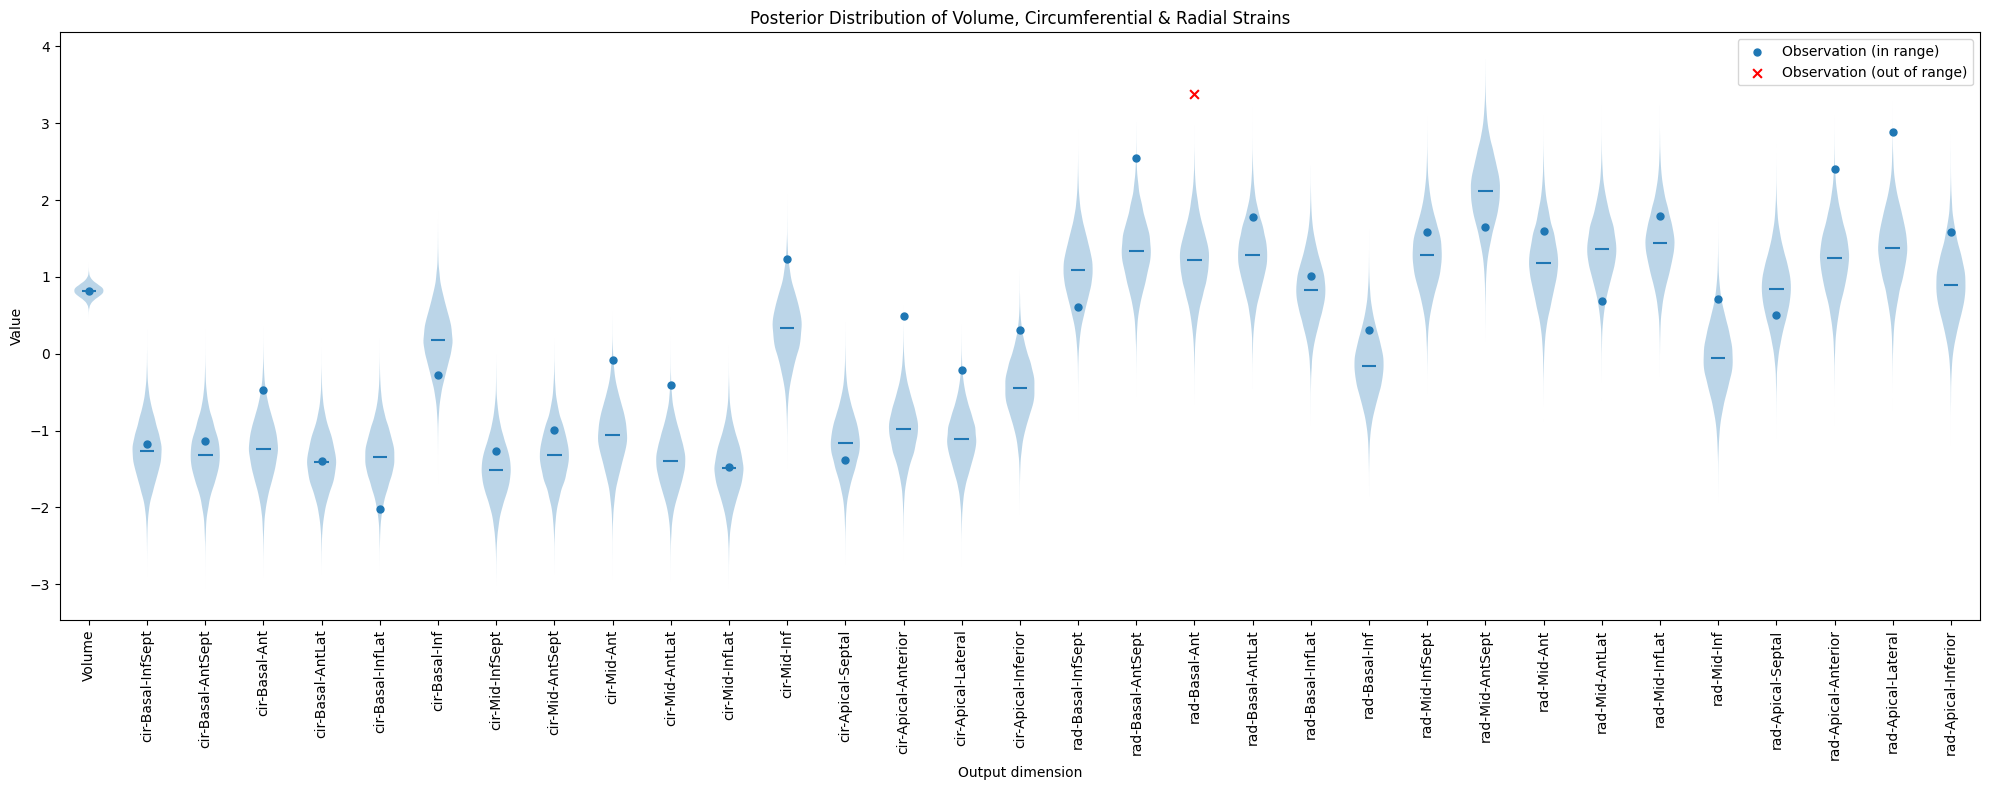

In [12]:
plot_violin_by_dim_with_truth(
    y_pp, 
    realcase_y, 
    dim_labels=CARDIAC_LABELS, # 传入标签
    max_points_per_dim=None,  # 可以根据需要调整这个值，或者设为 None 来使用所有点
    figsize=(20, 8)            # 画布高度加大，给旋转的标签留空间
)

# Inverse standardize

In [13]:
import torch
import joblib

scaler = joblib.load("RealCase/y_scaler_RealCase.joblib")

def inverse_standardize_torch(y: torch.Tensor, scaler) -> torch.Tensor:
    """
    y: torch Tensor, last dim must be D
    return: same shape as y, inversed to original scale
    """
    if not (hasattr(scaler, "mean_") and hasattr(scaler, "scale_")):
        raise TypeError("Scaler has no mean_/scale_. If this is not StandardScaler, use method B.")

    mean = torch.tensor(scaler.mean_, dtype=y.dtype, device=y.device)   # [D]
    scale = torch.tensor(scaler.scale_, dtype=y.dtype, device=y.device) # [D]
    return y * scale + mean

# ---- usage ----
# y_pp: [S,R,D]
y_pp_inv = inverse_standardize_torch(y_pp, scaler)

# y_true: [1,D] or [D]
y_true_t = realcase_y.squeeze(0) if (realcase_y.dim() == 2 and realcase_y.shape[0] == 1) else realcase_y
y_true_inv = inverse_standardize_torch(y_true_t, scaler)  # [D]


# Histogram for Volum Violin for remaining dims

In [14]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ── 1. 样式与颜色配置 ──────────────────────────────────────
JRSS_STYLE = {
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "axes.linewidth": 0.6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
}

COLORS = {
    "hist": "#4878CF",      # 柔蓝
    "hist_edge": "#2B5DA5",
    "violin": "#B0C4DE",    # 淡钢蓝
    "truth": "#C44E52",     # 砖红
    "ci": "#888888"         # 灰色
}

In [15]:
def prepare_ppc_data(y_pp, y_true, first_dim, max_hist_points, max_points_per_dim):
    """处理输入数据，返回绘图所需的 NumPy 数组和列表"""
    D = y_pp.shape[2]
    y_dim = y_pp.permute(2, 0, 1).contiguous().reshape(D, -1)
    N = y_dim.shape[1]

    # 直方图数据采样
    first_samples = y_dim[first_dim]
    if max_hist_points and first_samples.numel() > max_hist_points:
        idx = torch.randperm(first_samples.numel())[:max_hist_points]
        first_samples = first_samples[idx]

    # 其余维度数据采样
    rest_dims = [d for d in range(D) if d != first_dim]
    rest_samples = y_dim[rest_dims]
    if max_points_per_dim and N > max_points_per_dim:
        idx = torch.randperm(N)[:max_points_per_dim]
        rest_samples = rest_samples[:, idx]

    return (
        first_samples.detach().cpu().numpy(),
        y_true.detach().cpu().numpy().flatten(),
        [rest_samples[i].detach().cpu().numpy() for i in range(rest_samples.shape[0])],
        rest_dims
    )

## Volum histogram

In [16]:
def plot_single_dim_histogram(
    y_pp: torch.Tensor, 
    y_true: torch.Tensor, 
    target_dim: int = 0, 
    dim_label: str = None,
    bins: int = 50, 
    density: bool = True, 
    credible_level: float = 0.95,
    max_hist_points: int = 200_000,
    figsize: tuple = (6.5, 3.5),
    save_path: str = None
):
    """在独立的画布上绘制单一维度的直方图"""
    
    # 1. 提取单维数据
    D = y_pp.shape[2]
    target_samples = y_pp.permute(2, 0, 1).contiguous().reshape(D, -1)[target_dim]
    
    if max_hist_points and target_samples.numel() > max_hist_points:
        idx = torch.randperm(target_samples.numel(), device=target_samples.device)[:max_hist_points]
        target_samples = target_samples[idx]
        
    data_np = target_samples.detach().cpu().numpy()
    
    y_true_np = y_true.detach().cpu().numpy()
    if y_true_np.ndim == 2: y_true_np = y_true_np.squeeze(0)
    truth_val = y_true_np[target_dim]
    
    label = dim_label if dim_label else str(target_dim + 1)
    
    # 2. 计算 CI
    alpha = 1 - credible_level
    ci_lo, ci_hi = np.percentile(data_np, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    
    # 3. 独立绘图
    with mpl.rc_context(JRSS_STYLE):
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.hist(data_np, bins=bins, density=density, color=COLORS["hist"], 
                edgecolor=COLORS["hist_edge"], linewidth=0.3, alpha=0.85, zorder=2)
        
        ax.axvline(truth_val, color=COLORS["truth"], linestyle="--", linewidth=1.2, zorder=4, label="Observed")
        ax.axvline(ci_lo, color=COLORS["ci"], linestyle=":", linewidth=0.8, zorder=3)
        ax.axvline(ci_hi, color=COLORS["ci"], linestyle=":", linewidth=0.8, zorder=3, 
                   label=f"{credible_level*100:.0f}% CI")
        
        ax.set_title(f"Posterior predictive — {label[target_dim]}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Density" if density else "Count")
        ax.legend(loc="upper right")
        # fig.dpi = 300
        
        if save_path:
            fig.savefig(save_path, dpi=600)
        plt.show()
        
    return fig

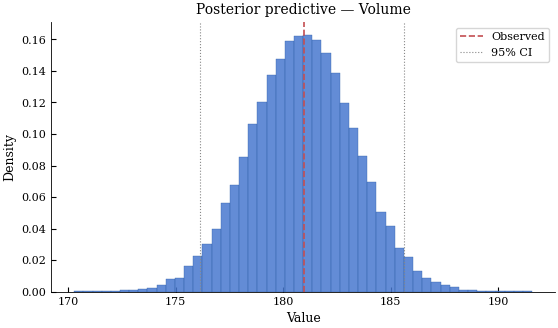

In [17]:
_ = plot_single_dim_histogram(y_pp_inv, y_true_inv, target_dim=0, dim_label=CARDIAC_LABELS, save_path="RealCase_Volume_histogram.svg")

## Violin

In [18]:
def plot_rest_dims_violin(
    y_pp: torch.Tensor, 
    y_true: torch.Tensor, 
    rest_dims: list = None,
    # exclude_dim: int = 0, 
    dim_labels: list = None,
    credible_level: float = 0.95,
    max_points_per_dim: int = 6000,
    figsize: tuple = (20, 5),
    label_rotation: int = 90,
    save_path: str = None
):
    """在独立的画布上绘制剩余维度的小提琴图"""
    
    D = y_pp.shape[2]
    y_dim = y_pp.permute(2, 0, 1).contiguous().reshape(D, -1)
    N = y_dim.shape[1]
    
    # rest_dims = [d for d in range(D) if d != exclude_dim]
    rest_samples = y_dim[rest_dims]
    
    if max_points_per_dim and N > max_points_per_dim:
        idx = torch.randperm(N, device=rest_samples.device)[:max_points_per_dim]
        rest_samples = rest_samples[:, idx]
        
    data_list = [rest_samples[i].detach().cpu().numpy() for i in range(rest_samples.shape[0])]
    
    y_true_np = y_true.detach().cpu().numpy()
    if y_true_np.ndim == 2: y_true_np = y_true_np.squeeze(0)
    truth_list = y_true_np[rest_dims]
    
    # if dim_labels is None:
    #     dim_labels = [str(i + 1) for i in range(D)]
    
    # if len(dim_labels) != D:
    #     print(f"Warning: dim_labels length ({len(dim_labels)}) != D ({D}). Using indices instead.")
    #     dim_labels = [str(i + 1) for i in range(D)]
        
    alpha = 1 - credible_level
    positions = np.arange(1, len(rest_dims) + 1)
    
    with mpl.rc_context(JRSS_STYLE):
        fig, ax = plt.subplots(figsize=figsize)
        
        vp = ax.violinplot(data_list, positions=positions, showextrema=False)
        for body in vp["bodies"]:
            body.set_facecolor(COLORS["violin"])
            body.set_edgecolor(COLORS["hist_edge"])
            body.set_linewidth(0.5)
            body.set_alpha(0.75)
            
        for i, data in enumerate(data_list):
            lo, hi = np.percentile(data, [100 * alpha / 2, 100 * (1 - alpha / 2)])
            pos = positions[i]
            ax.vlines(pos, lo, hi, color=COLORS["ci"], linewidth=0.6, zorder=3)
        
        # --- 红色/蓝色 区分逻辑 ---
        in_range_x, in_range_y = [], []
        out_range_x, out_range_y = [], []

        for i, data in enumerate(data_list):
            t_val = truth_list[i]
            v_min, v_max = np.min(data), np.max(data)
            pos = positions[i]
            
            if t_val < v_min or t_val > v_max:
                out_range_x.append(pos)
                out_range_y.append(t_val)
            else:
                in_range_x.append(pos)
                in_range_y.append(t_val)

        if in_range_x:
            ax.scatter(in_range_x, in_range_y, marker="D", s=15, zorder=6,
                       color=COLORS["truth"], edgecolors="k", linewidths=0.4,
                       label="Observed (in range)")
        if out_range_x:
            ax.scatter(out_range_x, out_range_y, marker="x", s=30, zorder=6,
                       color="red", linewidths=1.0,
                       label="Observed (out of range)")
        
        ax.set_title("Posterior predictive — Strains")
        ax.set_xlabel("Output dimension")
        ax.set_ylabel("Value")
        ax.set_xticks(positions)
        ax.set_xticklabels([dim_labels[d] for d in rest_dims], rotation=label_rotation)
        ax.set_xlim(0.5, len(rest_dims) + 0.5)
        
        legend_elements = [
            Patch(facecolor=COLORS["violin"], edgecolor=COLORS["hist_edge"], alpha=0.75, label="Predictive"),
            Line2D([], [], color=COLORS["ci"], linewidth=0.6, label=f"{credible_level*100:.0f}% CI"),
            Line2D([], [], marker="D", color="none", markerfacecolor=COLORS["truth"], markeredgecolor="k", markersize=5, label="Observed (in range)"),
            Line2D([], [], marker="x", color="red", linestyle="none", markersize=6, label="Observed (out of range)"),
        ]
        ax.legend(handles=legend_elements, loc="upper right", ncol=2)
        
        fig.tight_layout()
        
        if save_path:
            fig.savefig(save_path, dpi=600, bbox_inches="tight")
        plt.show()
        
    return fig

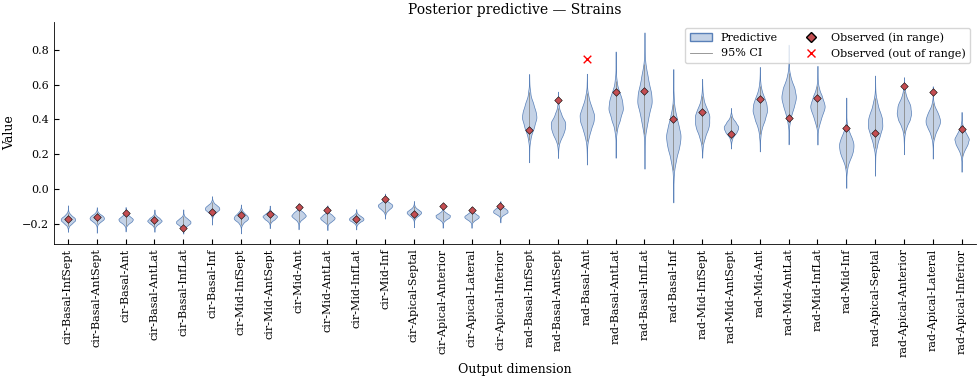

In [19]:
_ = plot_rest_dims_violin(y_pp_inv, y_true_inv, rest_dims=list(range(1,33)), dim_labels=CARDIAC_LABELS, figsize=(10, 4.0), save_path="RealCase_strains_violin.svg")

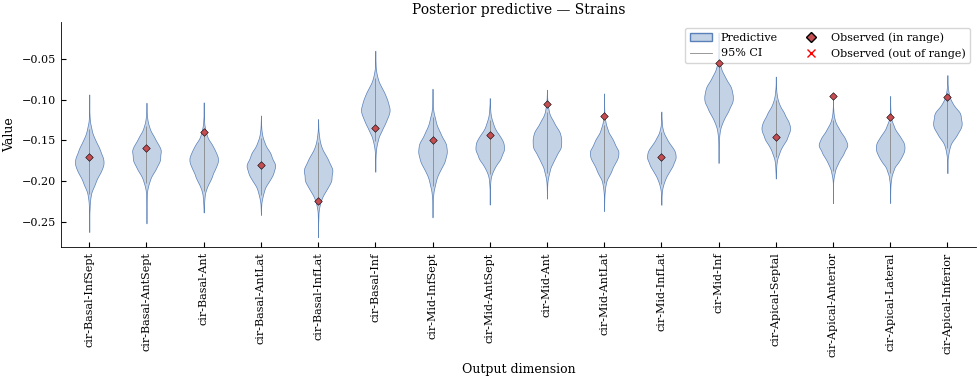

In [20]:
_ = plot_rest_dims_violin(y_pp_inv, y_true_inv, rest_dims=list(range(1,17)), dim_labels=CARDIAC_LABELS, figsize=(10, 4.0), save_path="RealCase_cir_strains_violin.svg")

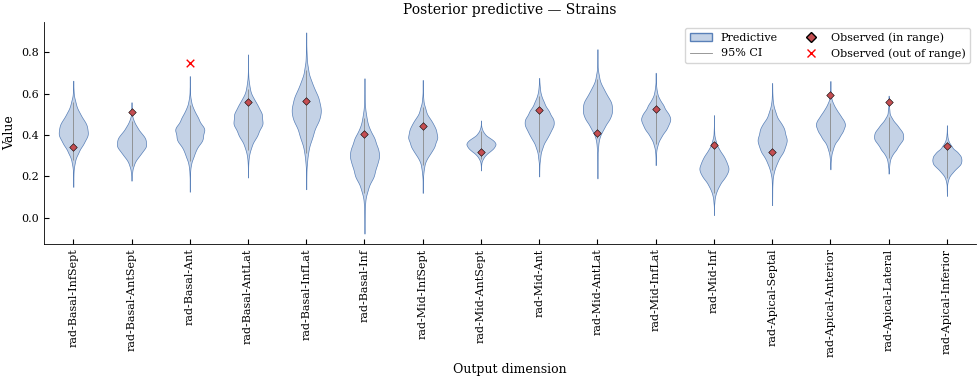

In [21]:
_ = plot_rest_dims_violin(y_pp_inv, y_true_inv, rest_dims=list(range(17,33)), dim_labels=CARDIAC_LABELS, figsize=(10, 4.0), save_path="RealCase_rad_strains_violin.svg")

## Violin - bias

In [22]:
def plot_rest_dims_bias_violin(
    y_pp: torch.Tensor, 
    y_true: torch.Tensor, 
    rest_dims: list = None,
    dim_labels: list = None,
    credible_level: float = 0.95,
    max_points_per_dim: int = 6000,
    figsize: tuple = (20, 5),
    label_rotation: int = 90,
    group_boundaries: list = None,
    save_path: str = None
):
    
    D = y_pp.shape[2]
    y_dim = y_pp.permute(2, 0, 1).contiguous().reshape(D, -1)  # (D, N)
    N = y_dim.shape[1]
    
    y_true_np = y_true.detach().cpu().numpy()
    if y_true_np.ndim == 2:
        y_true_np = y_true_np.squeeze(0)
    
    # 计算 bias: y_pp - y_true (每个维度广播减去标量真值)
    bias_dim = y_dim.clone()
    for d in rest_dims:
        bias_dim[d] = y_dim[d] - y_true_np[d]
    
    rest_samples = bias_dim[rest_dims]
    
    if max_points_per_dim and N > max_points_per_dim:
        idx = torch.randperm(N, device=rest_samples.device)[:max_points_per_dim]
        rest_samples = rest_samples[:, idx]
        
    data_list = [rest_samples[i].detach().cpu().numpy() for i in range(rest_samples.shape[0])]
    
    alpha = 1 - credible_level
    positions = np.arange(1, len(rest_dims) + 1)
    
    with mpl.rc_context(JRSS_STYLE):
        fig, ax = plt.subplots(figsize=figsize)
        
        vp = ax.violinplot(data_list, positions=positions, showextrema=False)
        for body in vp["bodies"]:
            body.set_facecolor(COLORS["violin"])
            body.set_edgecolor(COLORS["hist_edge"])
            body.set_linewidth(0.5)
            body.set_alpha(0.75)
            
        # for i, data in enumerate(data_list):
        #     lo, hi = np.percentile(data, [100 * alpha / 2, 100 * (1 - alpha / 2)])
        #     pos = positions[i]
        #     ax.vlines(pos, lo, hi, color=COLORS["ci"], linewidth=0.6, zorder=3)
        
        # 零线：无偏参考
        ax.axhline(0, color="k", linestyle="--", linewidth=0.8, alpha=0.6, zorder=2)

        # ---- 分组分界线 ----
        if group_boundaries:
            for left_label, right_label, boundary_dim in group_boundaries:
                # 找到 boundary_dim 在 rest_dims 中的位置索引
                if boundary_dim in rest_dims:
                    idx_in_rest = rest_dims.index(boundary_dim)
                    boundary_x = positions[idx_in_rest] - 0.5  # 在两个 violin 之间
                    ax.axvline(boundary_x, color="grey", linestyle=":", 
                               linewidth=1.2, alpha=0.8, zorder=1)
                    # 在分界线两侧顶部标注组名
                    y_top = ax.get_ylim()[1]
                    ax.text(boundary_x - 5.3, y_top, left_label, 
                            ha="right", va="top", fontsize=9, fontstyle="italic", color="grey")
                    ax.text(boundary_x + 5.3, y_top, right_label, 
                            ha="left", va="top", fontsize=9, fontstyle="italic", color="grey")
        
        


        # 标记 CI 是否包含零
        covers_zero_x, covers_zero_y = [], []
        misses_zero_x, misses_zero_y = [], []

        for i, data in enumerate(data_list):
            lo, hi = np.percentile(data, [100 * alpha / 2, 100 * (1 - alpha / 2)])
            median_val = np.median(data)
            pos = positions[i]
            if lo <= 0 <= hi:
                covers_zero_x.append(pos)
                covers_zero_y.append(median_val)
            else:
                misses_zero_x.append(pos)
                misses_zero_y.append(median_val)

        
        ax.set_title("Posterior predictive bias — Strains")
        ax.set_xlabel("Output dimension")
        ax.set_ylabel("Bias  (predicted − observed)")
        ax.set_xticks(positions)
        ax.set_xticklabels([dim_labels[d] for d in rest_dims], rotation=label_rotation)
        ax.set_xlim(0.5, len(rest_dims) + 0.5)
        
        legend_elements = [
            Patch(facecolor=COLORS["violin"], edgecolor=COLORS["hist_edge"], alpha=0.75, label="Bias distribution"),
            # Line2D([], [], color=COLORS["ci"], linewidth=0.6, label=f"{credible_level*100:.0f}% CI"),
            Line2D([], [], color="k", linestyle="--", linewidth=0.8, label="Zero bias"),

        ]
        ax.legend(handles=legend_elements, loc="upper right", ncol=2)
        
        fig.tight_layout()
        
        if save_path:
            fig.savefig(save_path, dpi=600, bbox_inches="tight")
        plt.show()
        
    return fig

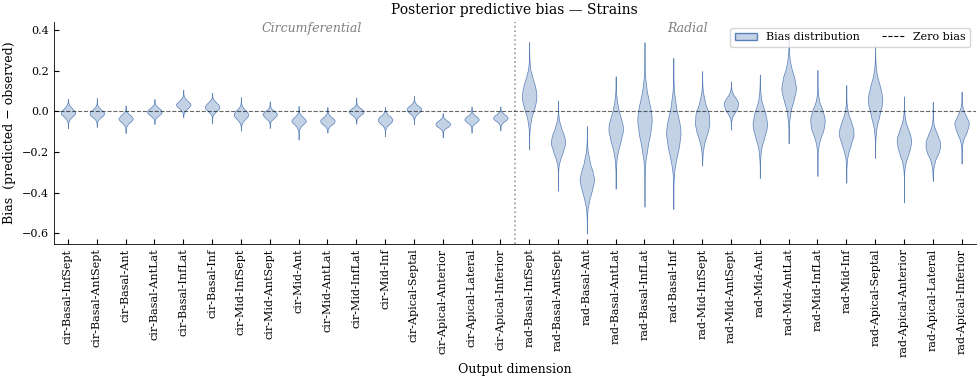

In [23]:
_ = plot_rest_dims_bias_violin(y_pp_inv, y_true_inv, rest_dims=list(range(1,33)), 
                               dim_labels=CARDIAC_LABELS, group_boundaries=[("Circumferential", "Radial", 17)],
                               figsize=(10, 4.0), save_path="RealCase_strains_violin_bias.svg")

# Random Projection PIT

In [24]:

def _empirical_quantile(sample_1d: np.ndarray, y: float) -> float:
    """q = P(sample <= y) estimated by empirical CDF."""
    return float(np.mean(sample_1d <= y))


def _unit_random_vectors(M: int, D: int, rng: np.random.Generator) -> np.ndarray:
    """Sample M random unit vectors in R^D."""
    U = rng.normal(size=(M, D))
    U /= np.linalg.norm(U, axis=1, keepdims=True) + 1e-12
    return U


# ── JRSS C rc 参数 ────────────────────────────────────────
_JRSSC_RC = {
    "font.family":        "serif",
    "font.serif":         ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset":   "cm",
    "font.size":          9,
    "axes.titlesize":     10,
    "axes.labelsize":     9,
    "xtick.labelsize":    8,
    "ytick.labelsize":    8,
    "legend.fontsize":    8,
    "axes.linewidth":     0.6,
    "xtick.major.width":  0.6,
    "ytick.major.width":  0.6,
    "xtick.direction":    "in",
    "ytick.direction":    "in",
    "xtick.major.pad":    3,
    "ytick.major.pad":    3,
    "legend.frameon":     False,
    "axes.grid":          False,
    "axes.spines.top":    False,
    "axes.spines.right":  False,
    "savefig.dpi":        600,
    "savefig.bbox":       "tight",
    "savefig.pad_inches": 0.03,
    "figure.dpi":         150,
}

# 配色
COL_HIST      = "#4878CF"
COL_HIST_EDGE = "#2B5DA5"
COL_MEDIAN    = "#C44E52"   # 砖红
COL_CI        = "#555555"   # 深灰


from collections import Counter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def typicality_check(
    X: np.ndarray,
    y: np.ndarray,
    *,
    alpha: float = 0.90,
    M: int = 200,
    seed: int = 0,
    make_plot: bool = True,
    figsize: tuple = (3.8, 2.8),
    bins: int = 20,
    save_path: str | None = None,
    dpi: int = 600,
):
    """
    Multivariate typicality check via marginal & random-projection PIT.
    Only the projection PIT histogram is plotted (publication quality).
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    N, D = X.shape
    assert y.shape[0] == D, f"y must have shape ({D},), got {y.shape}"

    rng = np.random.default_rng(seed)

    # ── 1) Marginal PIT quantiles ────────────────────────
    q_d = np.array([_empirical_quantile(X[:, d], y[d]) for d in range(D)])

    lo = (1 - alpha) / 2
    hi = 1 - lo
    C_marg = float(np.mean((q_d >= lo) & (q_d <= hi)))
    T_marg = float(np.mean(np.abs(q_d - 0.5)))

    # ── 2) Random projection PIT quantiles ───────────────
    U  = _unit_random_vectors(M, D, rng)
    sX = X @ U.T                                # (N, M)
    sy = y @ U.T                                # (M,)
    q_proj = np.mean(sX <= sy[None, :], axis=0) # (M,)

    C_proj = float(np.mean((q_proj >= lo) & (q_proj <= hi)))
    T_proj = float(np.mean(np.abs(q_proj - 0.5)))


    if make_plot:
        with mpl.rc_context(_JRSSC_RC):
            fig, ax = plt.subplots(1, 1, figsize=figsize)

            # 直方图
            ax.hist(
                q_proj, bins=bins, density=True,
                color=COL_HIST, edgecolor=COL_HIST_EDGE,
                linewidth=0.3, alpha=0.85, zorder=2,
            )

            # Uniform(0,1) 参考线
            ax.axhline(1.0, color="k", linewidth=0.5, linestyle="-",
                       zorder=1, alpha=0.4)

            # 中位线
            ax.axvline(0.5, color=COL_MEDIAN, linewidth=0.9,
                       linestyle="--", zorder=3)

            # 轴标签（LaTeX 数学排版）
            ax.set_xlabel(
                r"$\hat{q}^{(m)} = \hat{P}\left(\mathbf{u}^{\top}"
                r"\mathbf{X} \leq \mathbf{u}^{\top} \mathbf{y}\right)$"
            )
            ax.set_ylabel("Density")
            ax.set_xlim(-0.02, 1.02)

            # 图例
            handles = [
                Line2D([], [], color=COL_MEDIAN, linestyle="--",
                       linewidth=0.9, label="Median"),
                Line2D([], [], color="k", linewidth=0.5, alpha=0.4,
                       label=r"$\mathrm{Uniform}(0,1)$"),
            ]
            ax.legend(handles=handles, loc="upper right")

            # 右上角标注覆盖率 & M
            ax.text(
                0.97, 0.78,
                f"$C_{{\\mathrm{{proj}}}} = {C_proj:.2f}$\n$M = {M}$",
                transform=ax.transAxes, ha="right", va="top",
                fontsize=8,
            )

            if save_path:
                fig.savefig(save_path, dpi=dpi)
                print(f"Figure saved → {save_path}")
            plt.show()


    return fig


Figure saved → RealCase_RP_PIT.svg


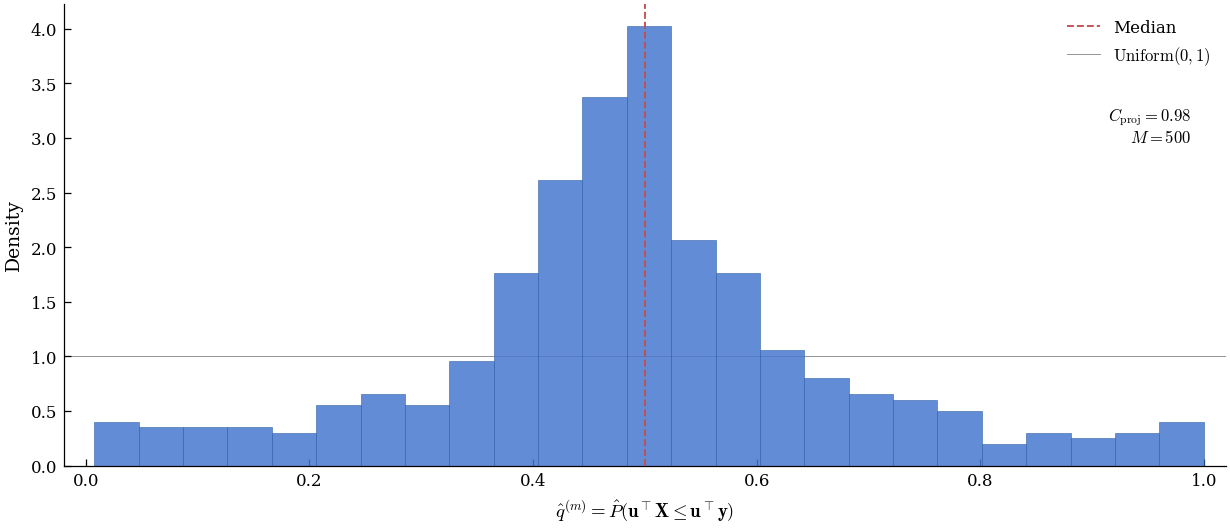

In [25]:
_ = typicality_check(y_pp_inv.reshape(-1, 33), y_true_inv, alpha=0.95, M=500, seed=10, 
                     make_plot=True,
                     figsize=(10, 4.0), bins=25,
                     save_path="RealCase_RP_PIT.svg")

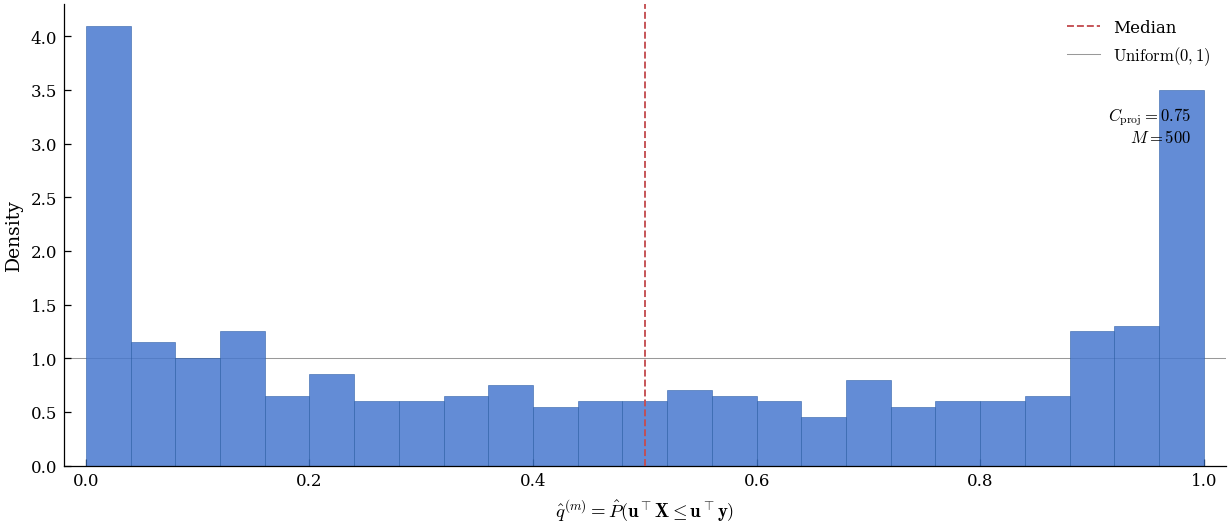

In [26]:
_ = typicality_check(y_pp_inv.reshape(-1, 33)[:,1:17], y_true_inv[1:17], alpha=0.95, M=500, seed=10, 
                     make_plot=True,
                     figsize=(10, 4.0), bins=25,
                     save_path=None)

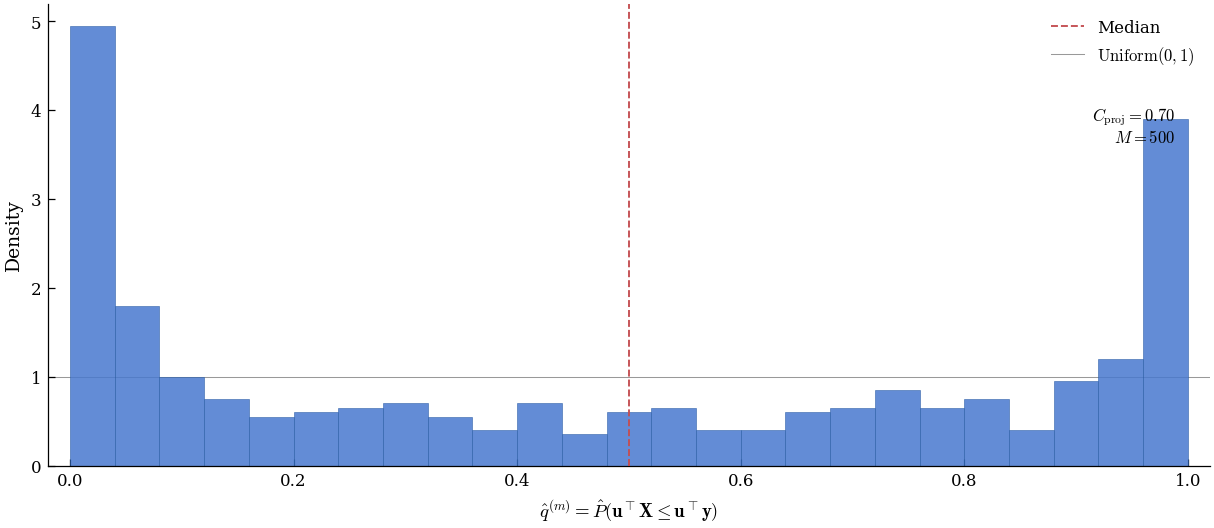

In [27]:
_ = typicality_check(y_pp_inv.reshape(-1, 33)[:,17:33], y_true_inv[17:33], alpha=0.95, M=500, seed=10, 
                     make_plot=True,
                     figsize=(10, 4.0), bins=25,
                     save_path=None)

In [179]:
def check_1d_pit(
    X: np.ndarray,
    y: np.ndarray,
    *,
    alpha: float = 0.90,
    make_plot: bool = True,
    figsize: tuple = (4.5, 3.5),
    bins: int = 20,
    title: str = "1D PIT Histogram",
):
    """
    1维数据的 PIT (Probability Integral Transform) 检验。
    计算 y 中每个观测值在 X 的经验分布中的分位数，并绘制直方图。
    """
    X = np.asarray(X).flatten()
    y = np.asarray(y).flatten()
    N = len(X)
    
    # ── 1) 高效计算 1D PIT 分位数 ───────────────────────
    # 使用 searchsorted 极大地提升 1D 数组的分位数计算速度
    X_sorted = np.sort(X)
    # 计算 y 在 X 中的插入位置，除以 N 得到经验分位数 q
    q = np.searchsorted(X_sorted, y, side='right') / N
    
    # ── 2) 计算统计指标 ─────────────────────────────────
    lo = (1 - alpha) / 2
    hi = 1 - lo
    # 落在 (1-alpha) 置信区间内的比例
    C_marg = float(np.mean((q >= lo) & (q <= hi)))
    # 偏离中心 0.5 的平均绝对偏差
    T_marg = float(np.mean(np.abs(q - 0.5)))

    # ── 3) 绘制出版级质量的直方图 ───────────────────────
    fig = None
    if make_plot:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # 绘制 PIT 直方图
        ax.hist(
            q, bins=bins, density=True,
            color="#4C72B0", edgecolor="white",
            linewidth=0.5, alpha=0.85, zorder=2,
        )

        # 理想状态下的 Uniform(0,1) 参考线
        ax.axhline(1.0, color="k", linewidth=0.8, linestyle="-",
                   zorder=1, alpha=0.6)

        # 中位线
        ax.axvline(0.5, color="#C44E52", linewidth=1.2,
                   linestyle="--", zorder=3)

        # 轴标签 (使用 LaTeX 渲染数学公式)
        ax.set_xlabel(r"$\hat{q} = \hat{P}(X \leq y)$")
        ax.set_ylabel("Density")
        ax.set_xlim(-0.02, 1.02)
        ax.set_title(title, fontsize=10)

        # 图例
        handles = [
            Line2D([], [], color="#C44E52", linestyle="--",
                   linewidth=1.2, label="Median"),
            Line2D([], [], color="k", linewidth=0.8, alpha=0.6,
                   label=r"$\mathrm{Uniform}(0,1)$"),
        ]
        ax.legend(handles=handles, loc="upper right", fontsize=8)

        # 右上角标注统计量
        ax.text(
            0.96, 0.72,
            f"Coverage = {C_marg:.2f}\n"
            f"MAD = {T_marg:.3f}",
            transform=ax.transAxes, ha="right", va="top",
            fontsize=8, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
        )
        
        plt.tight_layout()
        plt.show()

    return {"q": q, "coverage": C_marg, "mad_from_median": T_marg, "fig": fig}



In [182]:
y_pp_inv.reshape(-1, 33)[:,0]

tensor([181.5226, 182.4071, 181.1590,  ..., 179.9969, 180.1391, 180.3612])

【场景 1】测试完美匹配的分布...


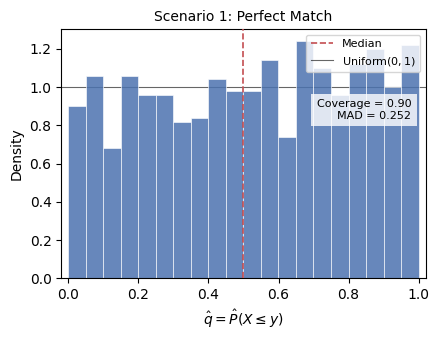

【场景 2】测试过度自信的预测 (方差偏小)...


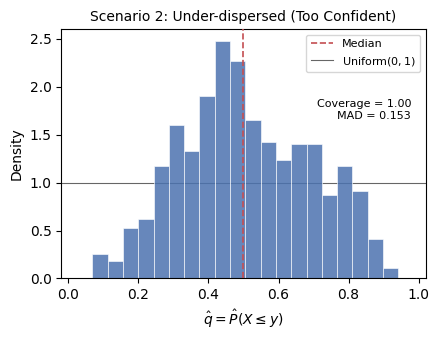

{'q': array([0.5504, 0.4928, 0.6804, 0.625 , 0.0726, 0.6114, 0.3092, 0.244 ,
        0.4626, 0.5828, 0.2108, 0.6464, 0.6592, 0.5126, 0.3358, 0.314 ,
        0.7098, 0.2296, 0.7146, 0.4686, 0.4838, 0.2002, 0.4712, 0.6266,
        0.2584, 0.6022, 0.522 , 0.376 , 0.6784, 0.1374, 0.5704, 0.804 ,
        0.7748, 0.5778, 0.4436, 0.3782, 0.443 , 0.6108, 0.3454, 0.658 ,
        0.8648, 0.491 , 0.2564, 0.2562, 0.6618, 0.4914, 0.6826, 0.3966,
        0.6744, 0.4696, 0.3596, 0.4224, 0.2816, 0.8486, 0.4838, 0.6332,
        0.3962, 0.304 , 0.4528, 0.7214, 0.4   , 0.3354, 0.5356, 0.6022,
        0.8066, 0.5712, 0.6332, 0.6494, 0.289 , 0.317 , 0.2976, 0.2586,
        0.6676, 0.5606, 0.52  , 0.1026, 0.8566, 0.3304, 0.856 , 0.24  ,
        0.345 , 0.1374, 0.5736, 0.295 , 0.2998, 0.2516, 0.6622, 0.6472,
        0.8292, 0.3682, 0.5494, 0.2664, 0.4362, 0.4004, 0.5934, 0.7082,
        0.7044, 0.3398, 0.7054, 0.4944, 0.4388, 0.3644, 0.3926, 0.8216,
        0.5636, 0.5394, 0.449 , 0.8948, 0.7578, 0.362 , 0.4

In [ ]:
rng = np.random.default_rng(42)

X_ref = rng.normal(loc=0.0, scale=1.0, size=5000)
y_perfect = rng.normal(loc=0.0, scale=1.0, size=1000)
check_1d_pit(X_ref, y_perfect, title="Scenario 1: Perfect Match")


y_underdispersed = rng.normal(loc=0.0, scale=0.5, size=1000)
check_1d_pit(X_ref, y_underdispersed, title="Scenario 2: Under-dispersed (Too Confident)")

In [183]:
def check_single_observation(
    X: np.ndarray,
    y_single: float,
    *,
    alpha: float = 0.95,
    make_plot: bool = True,
    figsize: tuple = (5, 3.5)
):
    """
    检验单个观测值 y_single 在参考分布 X 中是否典型。
    """
    X = np.asarray(X).flatten()
    N = len(X)
    
    # 计算 y_single 在 X 中的经验分位数 q
    # 使用 np.sum 直接计算小于等于 y_single 的比例
    q = np.sum(X <= y_single) / N
    
    # 判定是否在置信区间内
    lo = (1 - alpha) / 2
    hi = 1 - lo
    is_typical = lo <= q <= hi
    
    if make_plot:
        fig, ax = plt.subplots(figsize=figsize)
        
        # 画出参考数据 X 的直方图
        ax.hist(X, bins=30, density=True, color="#d3d3d3", edgecolor="white", label="Reference X")
        
        # 标出置信区间的边界 (比如 2.5% 和 97.5%)
        x_lo, x_hi = np.percentile(X, [lo * 100, hi * 100])
        ax.axvspan(x_lo, x_hi, color="#e0f0ff", alpha=0.5, zorder=0, label=f"{alpha*100:.0f}% Interval")
        
        # 标出单个观测值 y_single 的位置
        color = "#2ca02c" if is_typical else "#d62728" # 绿色代表正常，红色代表异常
        ax.axvline(y_single, color=color, linewidth=2, linestyle="--", 
                   label=f"y = {y_single:.2f} (q={q:.3f})")
        
        ax.set_title("Single Observation Typicality Check", fontsize=10)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend(loc="upper right", fontsize=8)
        
        # 在图上添加结论文本
        status = "Typical" if is_typical else "Atypical (Outlier)"
        ax.text(0.05, 0.95, f"Status: {status}\nQuantile (q): {q:.2%}", 
                transform=ax.transAxes, va='top', fontsize=9, fontweight='bold', color=color)
        
        plt.tight_layout()
        plt.show()

    return {"q": q, "is_typical": is_typical, "y_value": y_single}



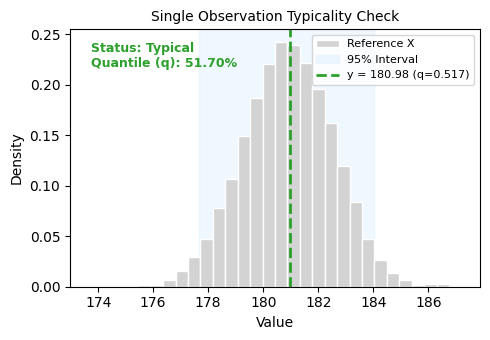

{'q': np.float64(0.517),
 'is_typical': np.True_,
 'y_value': array(180.97789, dtype=float32)}

In [187]:
check_single_observation(y_pp_inv.reshape(-1, 33)[:,0].numpy(), y_true_inv[0].numpy())

【测试 1】输入一个典型的正常值：


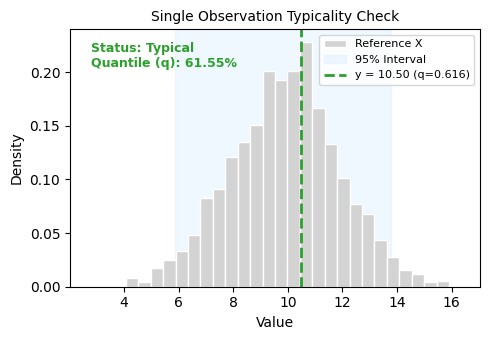


【测试 2】输入一个偏离极大的异常值：


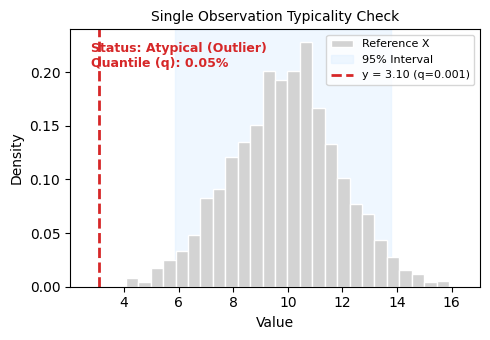

{'q': np.float64(0.0005), 'is_typical': np.False_, 'y_value': 3.1}

In [184]:

rng = np.random.default_rng(42)
X_ref = rng.normal(loc=10.0, scale=2.0, size=2000)

print("【测试 1】输入一个典型的正常值：")
check_single_observation(X_ref, y_single=10.5)

print("\n【测试 2】输入一个偏离极大的异常值：")
check_single_observation(X_ref, y_single=3.1)

# End